In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## Loading Dataset

In [97]:
customers = pd.read_csv('dataset/Customers.csv')
transactions = pd.read_csv('dataset/Transactions.csv')

In [98]:
merged_data = pd.merge(transactions, customers, on='CustomerID')

merged_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


## Data Preprocessing

In [99]:
total_spending = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)
total_spending.head()

,CustomerID,TotalSpending
0,C0001,3354.52
1,C0002,1862.74
2,C0003,2725.38
3,C0004,5354.88
4,C0005,2034.24


In [100]:
avg_transaction_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)
avg_transaction_value.head()

,CustomerID,AvgTransactionValue
0,C0001,670.904
1,C0002,465.685
2,C0003,681.345
3,C0004,669.360
4,C0005,678.080


In [101]:
num_transactions = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
num_transactions.rename(columns={'TransactionID': 'NumTransactions'}, inplace=True)
num_transactions.head()

,CustomerID,NumTransactions
0,C0001,5
1,C0002,4
2,C0003,4
3,C0004,8
4,C0005,3


In [102]:
customer_features = pd.merge(total_spending, avg_transaction_value, on='CustomerID')
customer_features = pd.merge(customer_features, num_transactions, on='CustomerID')
customer_features.head()

,CustomerID,TotalSpending,AvgTransactionValue,NumTransactions
0,C0001,3354.52,670.904,5
1,C0002,1862.74,465.685,4
2,C0003,2725.38,681.345,4
3,C0004,5354.88,669.360,8
4,C0005,2034.24,678.080,3


In [103]:
customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID')

customer_features.head()

,CustomerID,TotalSpending,AvgTransactionValue,NumTransactions,Region
0,C0001,3354.52,670.904,5,South America
1,C0002,1862.74,465.685,4,Asia
2,C0003,2725.38,681.345,4,South America
3,C0004,5354.88,669.360,8,South America
4,C0005,2034.24,678.080,3,Asia


In [104]:
# One-hot encode the region column
customer_features = pd.get_dummies(customer_features, columns=['Region'])
customer_features.head()

,CustomerID,TotalSpending,AvgTransactionValue,NumTransactions,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,670.904,5,False,False,False,True
1,C0002,1862.74,465.685,4,True,False,False,False
2,C0003,2725.38,681.345,4,False,False,False,True
3,C0004,5354.88,669.360,8,False,False,False,True
4,C0005,2034.24,678.080,3,True,False,False,False


In [105]:
scaler = MinMaxScaler()
features = ['TotalSpending', 'AvgTransactionValue', 'NumTransactions']
customer_features[features] = scaler.fit_transform(customer_features[features])

customer_features.head()

,CustomerID,TotalSpending,AvgTransactionValue,NumTransactions,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,0.308942,0.474336,0.4,False,False,False,True
1,C0002,0.168095,0.308940,0.3,True,False,False,False
2,C0003,0.249541,0.482751,0.3,False,False,False,True
3,C0004,0.497806,0.473092,0.7,False,False,False,True
4,C0005,0.184287,0.480120,0.2,True,False,False,False


In [106]:
X = customer_features.drop('CustomerID', axis=1)

## Clustering

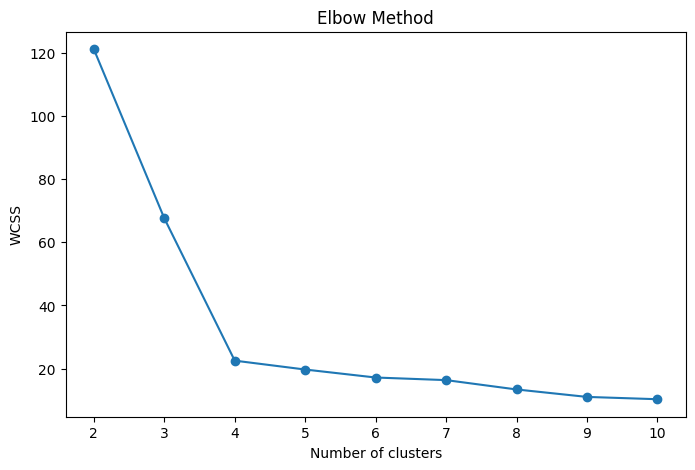

In [107]:
# Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

We can see that '4' is the elbow point

In [108]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X)

customer_features.head()

,CustomerID,TotalSpending,AvgTransactionValue,NumTransactions,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,0.308942,0.474336,0.4,False,False,False,True,2
1,C0002,0.168095,0.308940,0.3,True,False,False,False,3
2,C0003,0.249541,0.482751,0.3,False,False,False,True,2
3,C0004,0.497806,0.473092,0.7,False,False,False,True,2
4,C0005,0.184287,0.480120,0.2,True,False,False,False,3


## Metrics

In [109]:
db_index = davies_bouldin_score(X, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.4319307279812565


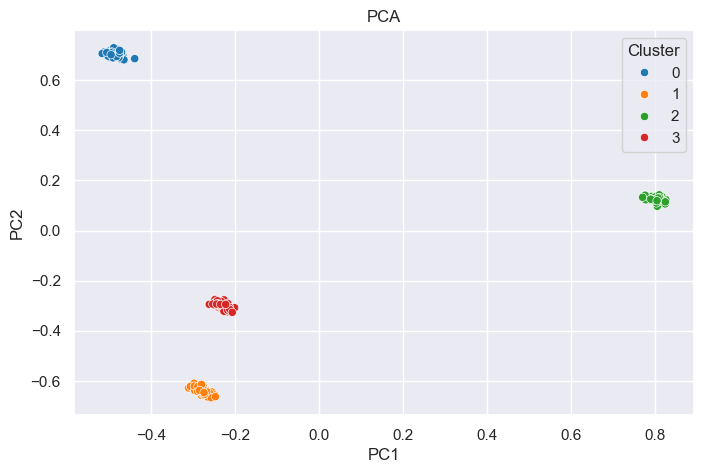

In [111]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

pca_df = pd.concat([pca_df, customer_features['Cluster']], axis=1)

sns.set_theme()
plt.figure(figsize=(8, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='tab10')
plt.title('PCA')
plt.show()

In [115]:
silhouette = silhouette_score(X, customer_features['Cluster'])
calinski_harabasz = calinski_harabasz_score(X, customer_features['Cluster'])

print(f'Silhouette Score: {silhouette}')
print(f'Calinski-Harabasz Score: {calinski_harabasz}')

Silhouette Score: 0.7167111219567973
Calinski-Harabasz Score: 429.43176493484316


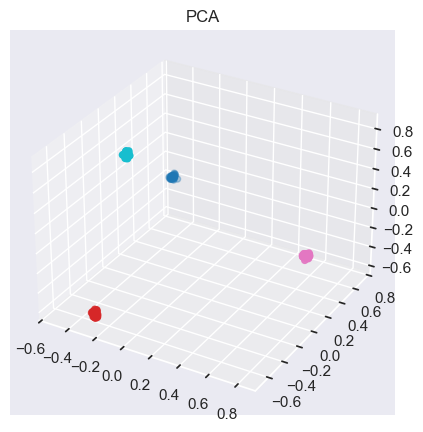

In [118]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])

pca_df = pd.concat([pca_df, customer_features['Cluster']], axis=1)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='tab10')
plt.title('PCA')
plt.show()